# Synthetic models for posterior distributions

Shivam Pandey (), Cyrille Doux (<doux@lpsc.in2p3.fr>), Marco Raveri (<marco.raveri@unige.it>)

In this notebook we show how to build normalizing flow syntetic models for posterior distributions, as in [Pandey, Doux and Raveri (2024), arXiv:XXXX.XXXX](https://arxiv.org/abs/XXXX.XXXXX).

In [1]:
# Show plots inline, and load main getdist plot module and samples class
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

# import libraries:
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../..')))
from getdist import plots, MCSamples
from getdist.gaussian_mixtures import GaussianND
import getdist
getdist.chains.print_load_details = False
import scipy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# import the tensiometer tools that we need:
import tensiometer
from tensiometer import utilities
from tensiometer import synthetic_probability

2024-07-07 22:15:57.181348: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We start by importing samples from the posterior distribution we are interested in. In this case we are going to use DES Y1 3x2 data:

In [2]:
# load the samples (remove no burn in since the example chains have already been cleaned):
chains_dir = './../../test_chains/'
# the DES Y1 3x2 chain:
chain = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'DES', no_cache=True)
# add omegab as a derived parameter:
if 'omegabh2' in chain.paramNames.list() and 'omegab' not in chain.paramNames.list():
    p = chain.getParams()
    _h = p.H0/100.
    chain.addDerived(p.omegabh2/_h**2, name='omegab', label='\\Omega_b')
    chain.updateBaseStatistics()

We then initialize and train the normalizing flow:

In [3]:
kwargs = {
          'feedback': 2,
          'plot_every': 1000,
          'pop_size': 1,
        }

param_names = ['H0', 'omegam', 'omegab', 'sigma8', 'ns']

flow = tensiometer.synthetic_probability.flow_from_chain(chain,  # parameter difference chain
                                                         param_names=param_names,
                                                         **kwargs)

* Initializing samples
    - flow name: DES_flow
    - precision: <dtype: 'float32'>
    - flow parameters and ranges:
      H0 : [20, 100]
      omegam : [0, 0.529376]
      omegab : [0.00542359, 0.158067]
      sigma8 : [0.544086, 1.35224]
      ns : [0.8, 1.2]
    - periodic parameters: []
* Initializing fixed bijector
    - using prior bijector: ranges
    - rescaling samples
* Initializing trainable bijector
    Building Autoregressive Flow
    - # parameters          : 5
    - periodic parameters   : None
    - # transformations     : 7
    - hidden_units          : [10, 10]
    - transformation_type   : affine
    - autoregressive_type   : masked
    - permutations          : True
    - scale_roto_shift      : False
    - activation            : <function asinh at 0x1c3626d30>
* Initializing training dataset
    - 87049/9672 training/test samples and non-uniform weights
    - 80733 effective number of training samples
    - 9058.77 effective number of test samples
* Initializing

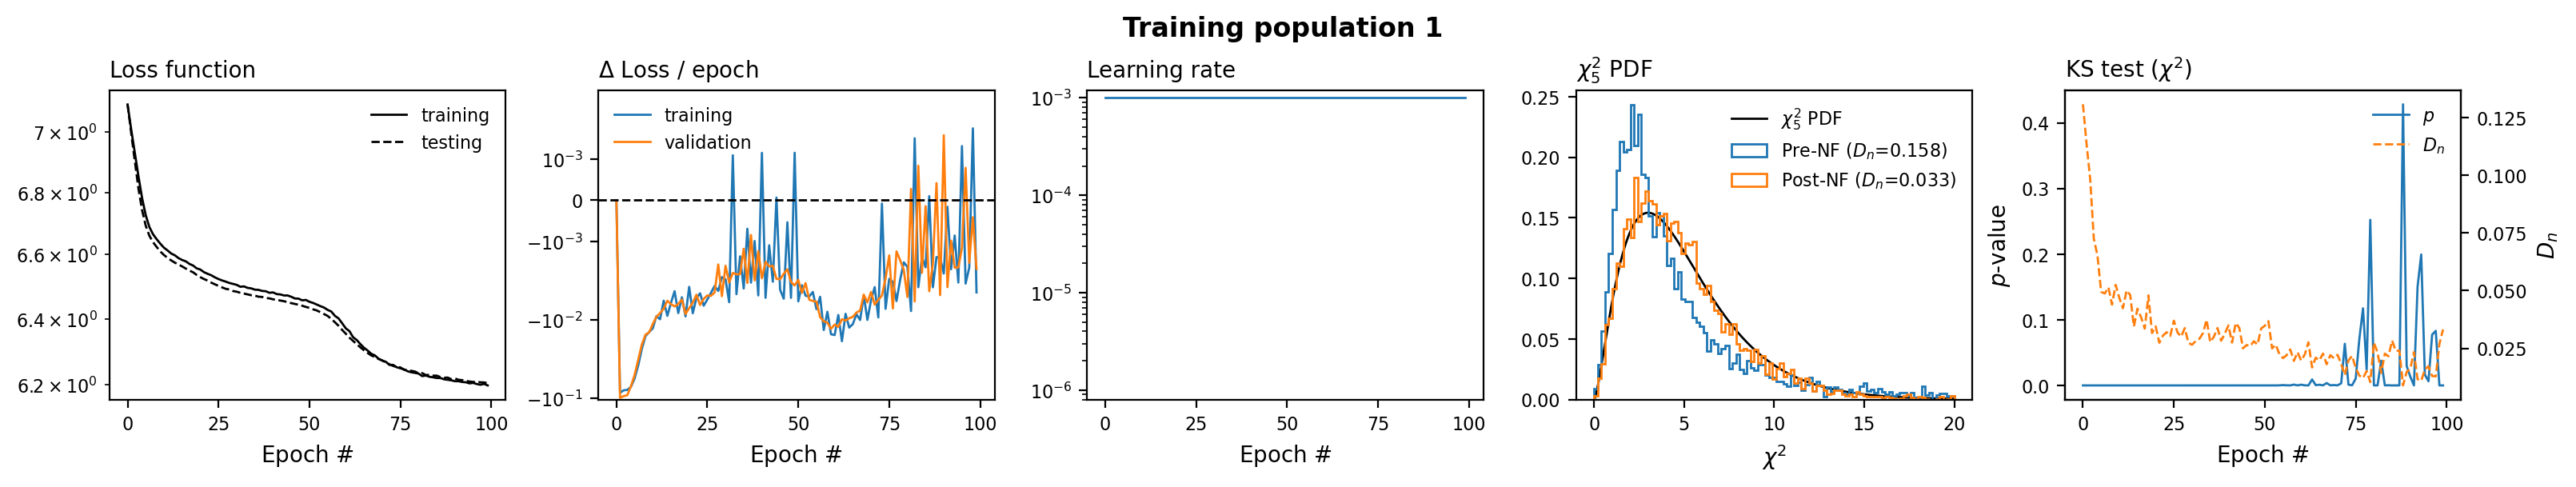

In [4]:
# we can plot training summaries to make sure training went smoothly:
flow.training_plot()

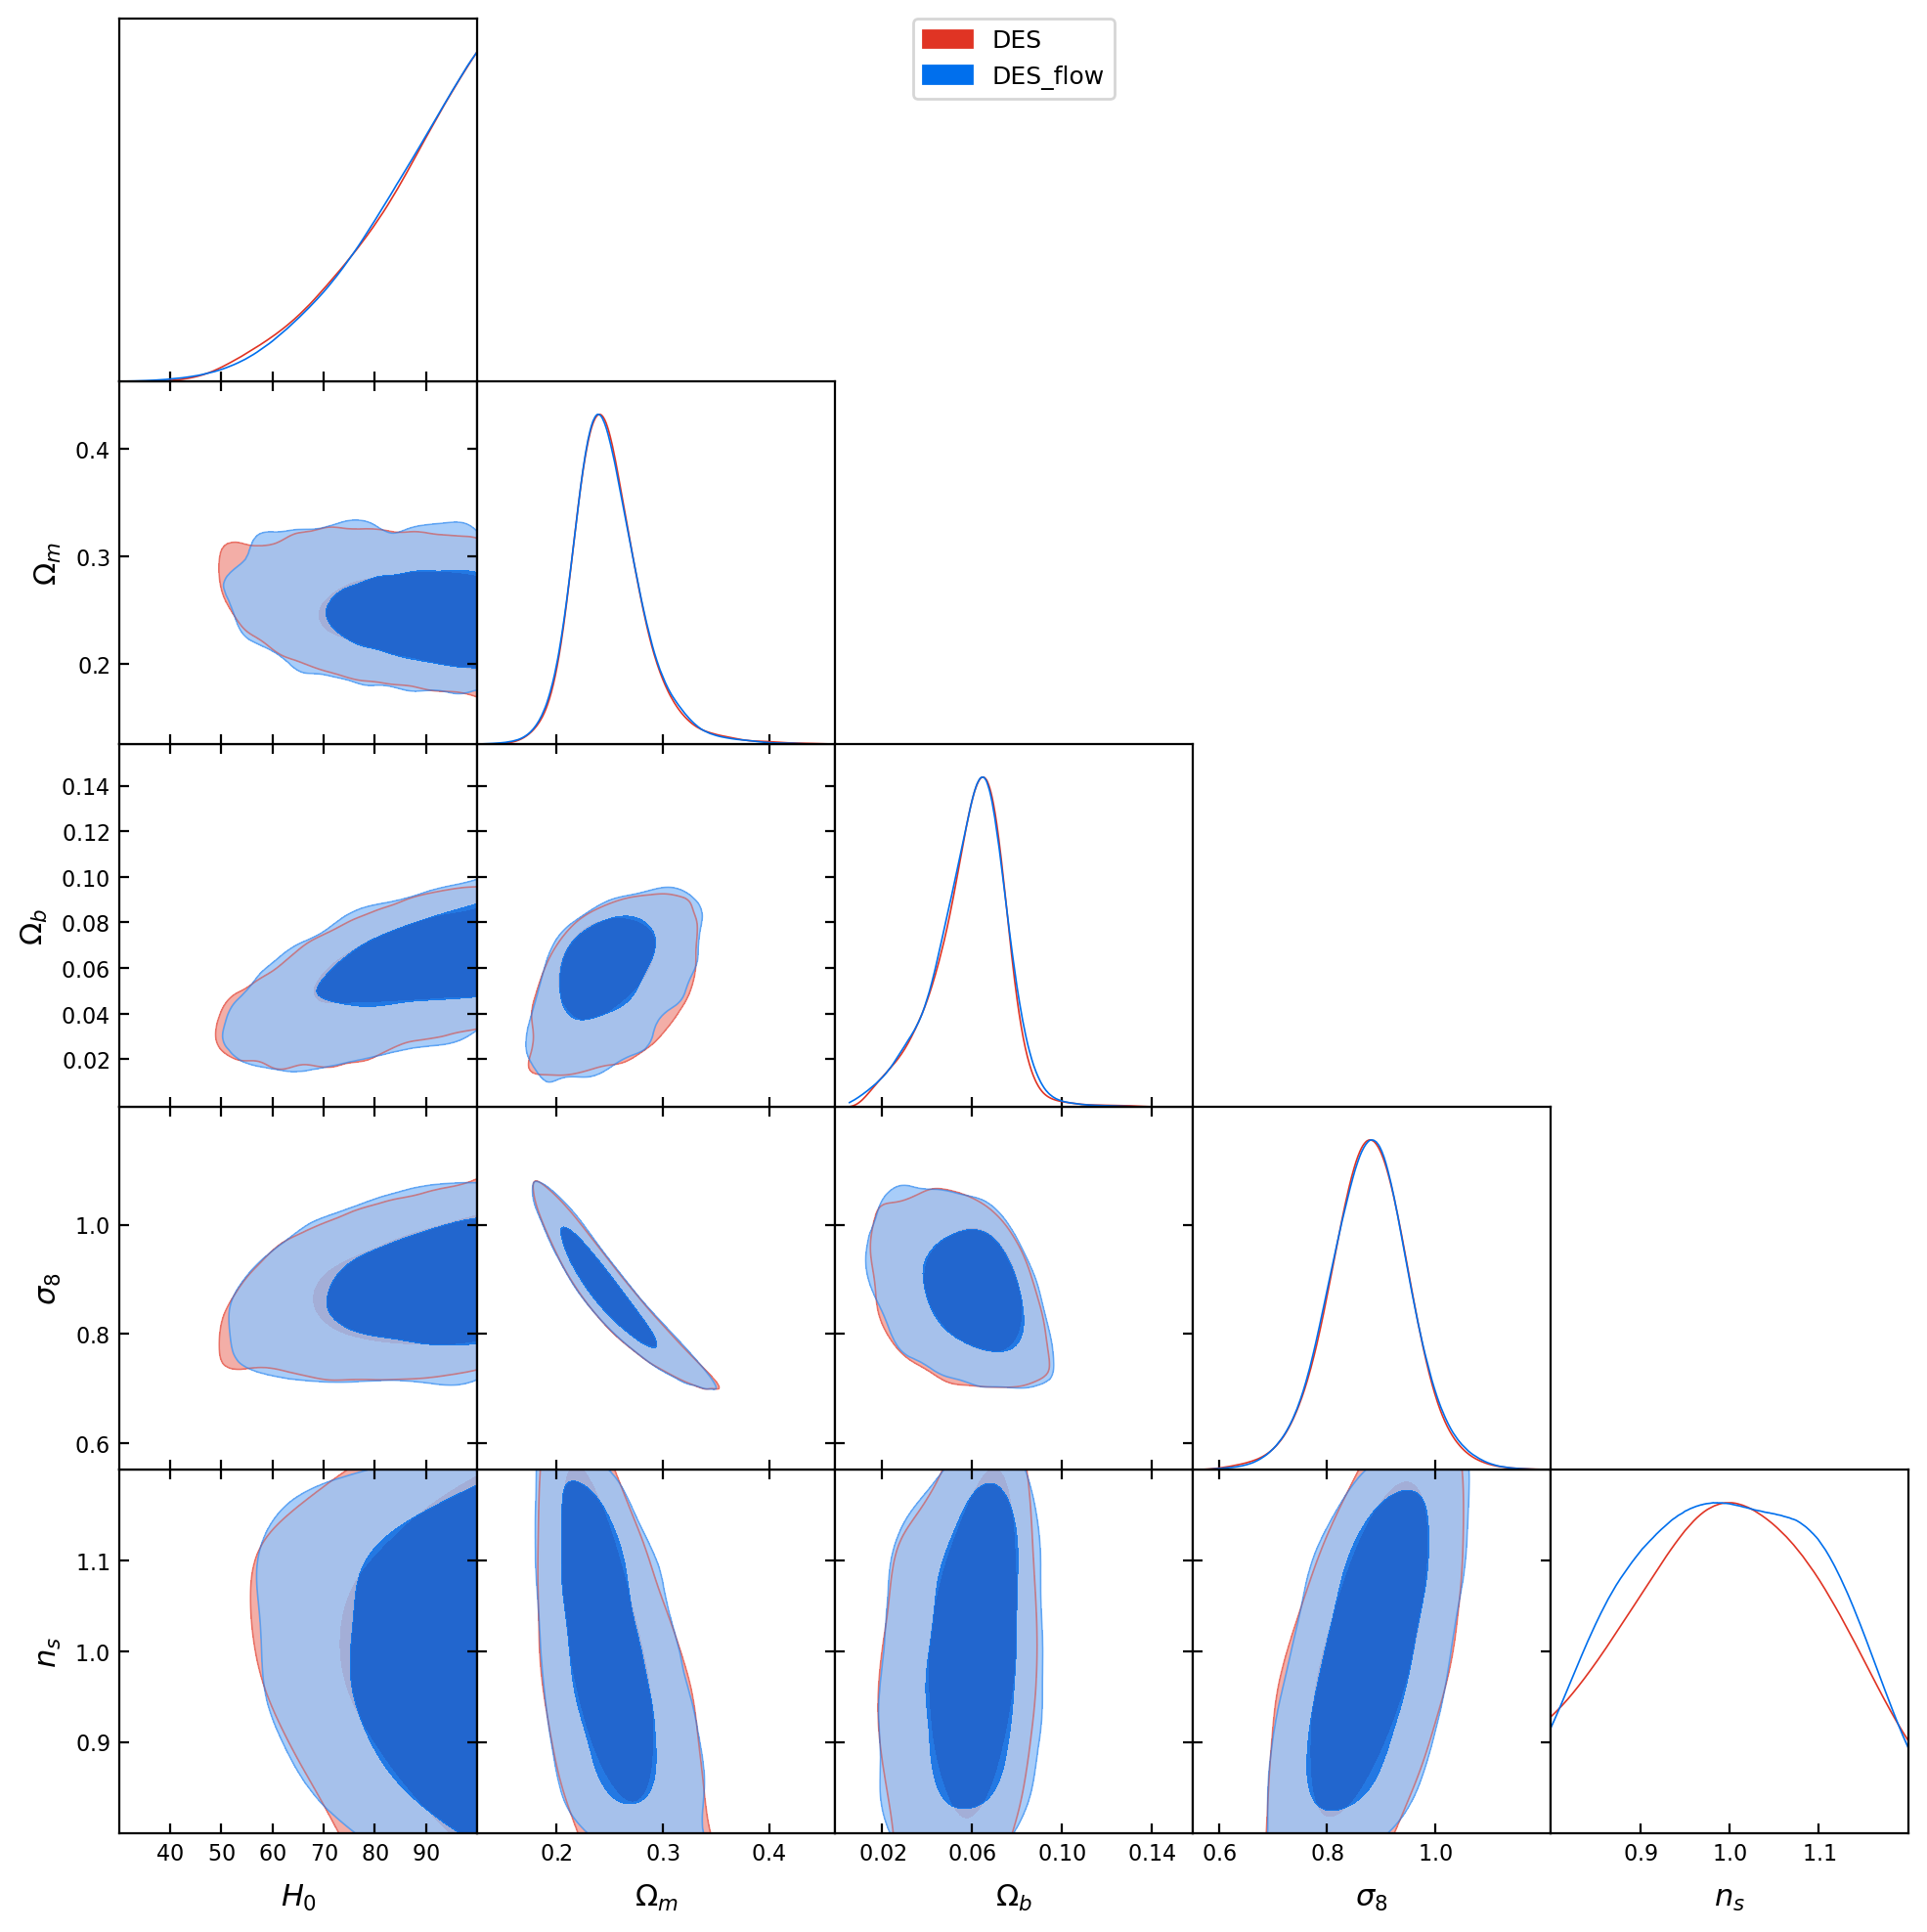

In [5]:
# we can triangle plot the flow to see how well it has learned the target distribution:
g = plots.get_subplot_plotter()
g.triangle_plot([chain, flow.MCSamples(10000)], 
                params=flow.param_names,
                filled=True)